# Classificação de Exoplanetas

### Welton Augusto Rodrigues Santos

In [2]:
import os

# Numpy
import numpy as np

# Pandas
import pandas as pd

## Matplotlib
import matplotlib.pyplot as plt

from sklearn.preprocessing import normalize

## Cross validation, GrideSearch (Model selection).
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, auc

## Classifiers.
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import KFold

# Definição de Métricas

### TP = Taxa de Verdadeiros Posítivos (classificados como positivos e são positivos)
### FP = Taxa de Falso Posítivos (classificados como não positivos e são negativos)
### TN = Taxa de Verdadeiros Negativos (classificados como negativos e são negativos)
### FN = Taxa de Falso Negativos (classificados como negativos e são positivos)

### Acurácia = TP + TN / (TP + TN + FP + FN)
### Precisão = TP / (TP + FP)
### Recall = TN / (TN + FN)
### F1-Score = 2 * (Precisão * Recall) / (Precisão + Recall)
### Curva Roc = Projeção da taxa TP contra a FN

In [3]:
originalDF = pd.read_csv('database/koi_data.csv', sep=',')
originalDF.head()

,kepoi_name,koi_disposition,koi_period,koi_impact,koi_duration,koi_depth,koi_ror,koi_srho,koi_prad,koi_sma,...,koi_fwm_srao,koi_fwm_sdeco,koi_fwm_prao,koi_fwm_pdeco,koi_dicco_mra,koi_dicco_mdec,koi_dicco_msky,koi_dikco_mra,koi_dikco_mdec,koi_dikco_msky
0,K00752.01,CONFIRMED,9.48804,0.146,2.95750,615.8,0.02234,3.20796,2.26,0.0853,...,0.430,0.940,-0.00020,-0.00055,-0.010,0.200,0.200,0.080,0.310,0.320
1,K00752.02,CONFIRMED,54.41838,0.586,4.50700,874.8,0.02795,3.02368,2.83,0.2734,...,-0.630,1.230,0.00066,-0.00105,0.390,0.000,0.390,0.490,0.120,0.500
2,K00754.01,FALSE POSITIVE,1.73695,1.276,2.40641,8079.2,0.38739,0.22080,33.46,0.0267,...,-0.111,0.002,0.00302,-0.00142,-0.249,0.147,0.289,-0.257,0.099,0.276
3,K00755.01,CONFIRMED,2.52559,0.701,1.65450,603.3,0.02406,1.98635,2.75,0.0374,...,-0.010,0.230,0.00008,-0.00007,0.030,-0.090,0.100,0.070,0.020,0.070
4,K00114.01,FALSE POSITIVE,7.36179,1.169,5.02200,233.7,0.18339,0.00485,39.21,0.0820,...,-13.450,24.090,0.00303,-0.00555,-4.506,7.710,8.930,-4.537,7.713,8.948


# Normalizando os dados

### Para evitar que variações no range dos atributos atrapalhem a predição de modo que atributos ganhem ou percam importância indevidamente normalizamos os valores de todos atributos dentro do intervalo de 0-1.

In [4]:
originalDF.columns

Index(['kepoi_name', 'koi_disposition', 'koi_period', 'koi_impact',
       'koi_duration', 'koi_depth', 'koi_ror', 'koi_srho', 'koi_prad',
       'koi_sma', 'koi_incl', 'koi_teq', 'koi_insol', 'koi_dor',
       'koi_max_sngle_ev', 'koi_max_mult_ev', 'koi_model_snr', 'koi_steff',
       'koi_slogg', 'koi_smet', 'koi_srad', 'koi_smass', 'koi_kepmag',
       'koi_gmag', 'koi_rmag', 'koi_imag', 'koi_zmag', 'koi_jmag', 'koi_hmag',
       'koi_kmag', 'koi_fwm_stat_sig', 'koi_fwm_sra', 'koi_fwm_sdec',
       'koi_fwm_srao', 'koi_fwm_sdeco', 'koi_fwm_prao', 'koi_fwm_pdeco',
       'koi_dicco_mra', 'koi_dicco_mdec', 'koi_dicco_msky', 'koi_dikco_mra',
       'koi_dikco_mdec', 'koi_dikco_msky'],
      dtype='object')

In [5]:
dataset_path = "database/df.csv"
if os.path.exists(dataset_path):
    df = pd.read_csv(dataset_path, sep=",")
else:
    target = originalDF["koi_disposition"]
    df_values = originalDF.drop(columns=["koi_disposition","kepoi_name"], axis=1)
    feats = normalize(df_values.values)
    df = pd.DataFrame(feats, columns=list(df_values.columns))
    df["koi_disposition"] = target
    df.to_csv(dataset_path, sep=",", index=False)


In [6]:
df.head(5)

,koi_period,koi_impact,koi_duration,koi_depth,koi_ror,koi_srho,koi_prad,koi_sma,koi_incl,koi_teq,...,koi_fwm_sdeco,koi_fwm_prao,koi_fwm_pdeco,koi_dicco_mra,koi_dicco_mdec,koi_dicco_msky,koi_dikco_mra,koi_dikco_mdec,koi_dikco_msky,koi_disposition
0,0.001710,0.000026,0.000533,0.110979,0.000004,5.781357e-04,0.000407,0.000015,0.016158,0.142914,...,1.694060e-04,-3.604382e-08,-9.912050e-08,-0.000002,0.000036,0.000036,0.000014,0.000056,0.000058,CONFIRMED
1,0.009815,0.000106,0.000813,0.157778,0.000005,5.453491e-04,0.000510,0.000049,0.016155,0.079899,...,2.218421e-04,1.190372e-07,-1.893774e-07,0.000070,0.000000,0.000070,0.000088,0.000022,0.000090,CONFIRMED
2,0.000172,0.000126,0.000238,0.798887,0.000038,2.183314e-05,0.003309,0.000003,0.006634,0.137940,...,1.977640e-07,2.986236e-07,-1.404124e-07,-0.000025,0.000015,0.000029,-0.000025,0.000010,0.000027,FALSE POSITIVE
3,0.000401,0.000111,0.000263,0.095887,0.000004,3.157066e-04,0.000437,0.000006,0.013575,0.223467,...,3.655575e-05,1.271504e-08,-1.112566e-08,0.000005,-0.000014,0.000016,0.000011,0.000003,0.000011,CONFIRMED
4,0.001146,0.000182,0.000782,0.036394,0.000029,7.552898e-07,0.006106,0.000013,0.009487,0.208989,...,3.751532e-03,4.718615e-07,-8.643007e-07,-0.000702,0.001201,0.001391,-0.000707,0.001201,0.001393,FALSE POSITIVE


# Funções de Suporte

### Funções para Tunar modelos, Plotar gráfico da acurácia e Avaliar os melhores modelos (precisão, recall e curva roc).

In [7]:
def hyper_tuning(df, clf, params, score="accuracy"):
    folds = 5
    kfolds = StratifiedKFold(n_splits=folds)
    X = df.drop(columns=["koi_disposition"], axis=1).values
    Y = df["koi_disposition"]
    grid_search_cv = GridSearchCV(clf, params, scoring=score, cv=kfolds, verbose=3, n_jobs=25)
    grid_search_cv.fit(X, Y)
    return grid_search_cv

def plot_graph(clf_scores, start, end, xlabel, ylabel="Accuracy"):
    x = list(range(start, end))
    fig, ax = plt.subplots()
    ax.grid()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    # Configurando intervalo de plot no eixo Y.
    ax.set_ylim([0,1])
    ax.plot(x, clf_scores)
    point = np.argmax(clf_scores)+1
    max_value = clf_scores[point]
    ax.plot([point],[max_value], linestyle='--', marker='o', color='red', label='Optimal Value - ACC = %0.2f' % max_value)
    ax.legend()

def plot_roc_curve(probs, y_test, roc_auc):

    preds = probs[:,1]
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc_aux = auc(fpr, tpr)

    fig, ax = plt.subplots()
    ax.set_title('Receiver Operating Characteristic')
    ax.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    ax.legend(loc = 'lower right')
    ax.plot([0, 1], [0, 1],'r--')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')
    ax.grid()

def map_label(x):

    if x == 'CONFIRMED':
        return 1
    return 0

def classe_prob(probs):

    classes = []
    for p in probs:
        if p > 0.5:
            classes.append(1)
        else:
            classes.append(0)
    
    return np.array(classes)

def analysis_best_estimator(df, best_clf):

    # Preparando o dado para treino e teste.
    X = df.drop(columns=["koi_disposition"], axis=1).values
    Y = list(map(map_label, df["koi_disposition"]))
    r = np.random
    seed = r.randint(100)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=seed)

    # Treinando o classificador.
    best_clf.fit(X_train, Y_train)
    probs = best_clf.predict_proba(X_test)
    Y_pred = classe_prob(probs[:,1])

    # Avaliando o classificador.
    precision = precision_score(Y_test, Y_pred)
    recall = recall_score(Y_test, Y_pred)
    roc_auc = roc_auc_score(Y_test, Y_pred)

    print("Precisão: ", precision)
    print("Recall: ", recall)
    print("ROC_AUC: ", roc_auc)

    # Plotando curva ROC.
    plot_roc_curve(probs, Y_test, roc_auc)

# Distribuição dos Dados

Text(0, 0.5, 'Qtde (%)')

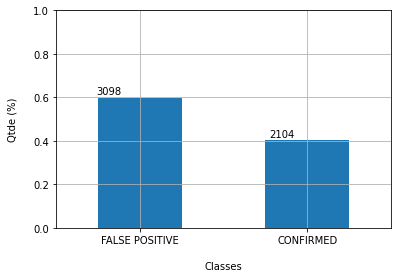

In [8]:
params = dict(grid = True, ylim=[0,1])
ax = df.koi_disposition.value_counts(normalize=True).plot(kind='bar', rot=0, **params)

values = df.koi_disposition.value_counts()

for p, v in zip(ax.patches, values):
    ax.annotate(str(v), (p.get_x() * 1.03, p.get_height() * 1.03))

plt.xlabel("Classes", labelpad=16)
plt.ylabel("Qtde (%)", labelpad=16)

### Os dados estão um pouco desbalanceados, porem nada que atrapalhe a classificação.

# Base Line (Nayve Bayes)
### Construindo baseline com algoritimo Naive Bayes. Para construir o baseline com este algoritimo utilizaremos a versão Gaussian Naive Bayes para lidar com valores reais.

Média (accuracy):  0.9188827311017513
Média (f1_macro):  0.9167560623872187
Precisão:  0.8579040852575488
Recall:  0.9378640776699029
ROC_AUC:  0.9180414535932211


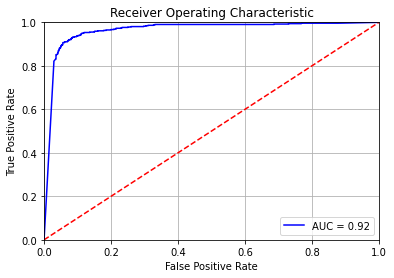

In [9]:

folds = 5
X = df.drop(columns=["koi_disposition"], axis=1).values
Y = df["koi_disposition"]
clf = GaussianNB()
scores = ["accuracy", "f1_macro"]
for score in scores:
    print(f"Média ({score}): ", sum(cross_val_score(clf, X, Y, cv=folds, scoring=score, n_jobs=15))/folds)

analysis_best_estimator(df, GaussianNB())


### O algoritmo Naive Bayes (Baseline de nosso experimento) obteve ~ 91.89 de acuurácia na predição das classes de planetas. A cobertura do mesmo ficou alta, que mostra tendência do modelo de classificar mais instâncias como confirmadas quando não estão. Isso corrobora com a precisão relativamente baixa em relação ao recall. Apesar da precisão estar afetada, o modelo conseguiu separar os dados ligeiramente bem, ficando com 92.61% de ROC_AUC.

# Decision Tree

### Estimando a altura máxima esperada da árvore. Para isso deixamos o atributo max_depth como padrão (que permite a árvore chegar na altura máxima) e variamos o parâmetro criterion com os valores 'gini' e 'entropy'. Conforme o cross_validation executado no gride search a altura máxima obtida foi 16.

In [10]:
# Testando a altura máxima esperada dá árvore.
k_folds = KFold(n_splits=5)

tree_clf = DecisionTreeClassifier()
params = {"criterion" : ["gini","entropy"]}
tree_clf = GridSearchCV(tree_clf, params, cv=k_folds)

tree_clf.fit(X, Y)
tree_clf_depth = tree_clf.best_estimator_
print("Max Depth Tree: ", tree_clf_depth.tree_.max_depth)

Max Depth Tree:  16


### Buscando por estimador ótimo para a árvore. Conforme aumentamos a altura da árvore, aumentamos a capacidade do modelo o que nos permite representar funções mais complexas, porém, aproxima o algoritimo de um possível super ajuste conforme a altura aumenta demais. Dessa forma nosso objetivo é encontrar a altura que maximize a acurácia do algoritimo, que reside no limite entre o underfitting e overfitting. Para encontrar a melhor altura da árvore dado dados os outros parâmetros como default da biblioteca Sklearn, utilizamos o Grid Search para procurar a altura do melhor estimador no intervalo de discreto [1, 20] (cobrindo o valor estimado pelo padrão da biblioteca do sklearn que é 16).

In [11]:
# Construindo o classificador e o conjunto de parâmetros para busca. Buscaremos até o a altura 20 (4 a mais do esperado).
tree_clf = DecisionTreeClassifier()
tree_params = {'max_depth': list(range(1, 20))}

# Buscando parâmetros.
tree_grid_search_cv = hyper_tuning(df, tree_clf, tree_params)


Fitting 5 folds for each of 19 candidates, totalling 95 fits


## Gráfico da acurácia obtida com o Decision Tree para cada valor de altura.

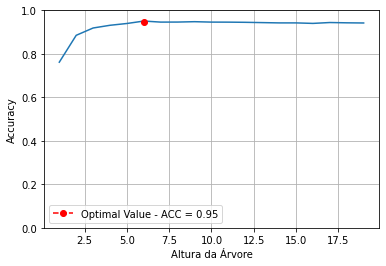

In [12]:
tree_mean_scores = tree_grid_search_cv.cv_results_["mean_test_score"]
plot_graph(tree_mean_scores, 1, len(tree_mean_scores)+1, "Altura da Árvore")

### O aumento da altura da árvore até o sexto nível foi importante, levando a acurácia inicial ~78% para ~96%. Para alturas maiores que seis, os modelos se mantiveram constantes, com perda de acurácia praticamente desprezível em relação ao melhor.

## Verificando a precisão, recall e ROC_AUC.

Precisão:  0.9233576642335767
Recall:  0.9656488549618321
ROC_AUC:  0.955797400453889


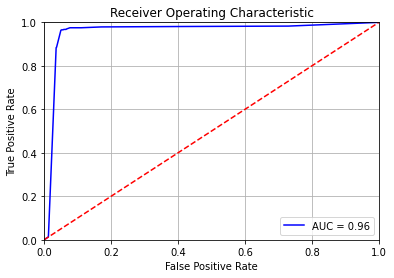

In [13]:
max_depth = tree_grid_search_cv.best_params_["max_depth"]
best_tree_clf = DecisionTreeClassifier(max_depth=max_depth)
analysis_best_estimator(df, best_tree_clf)

### O modelo gerado com o árvores de tamanho máximo 6, obteve um pouco mais de dificuldade para identificar planetas confirmados em meio a confirmados e não confirmados, o que justifica a precisão mais baixa e o recall mais alto. O modelo gerado tende ligeiramente a classificar mais planetas como confirmados do que deveria. Porém, manteve a curva roc equilibrada em relação ao recall, mostrando que ainda sim separou bem planetas confirmados de não confirmados.

# SVM (Suport Vector Machine)

### Análise do algoritmo SVM com diferentes funções de kernel para o problema de classificação de explanetas. A função de kernel permite ao SVM representar os dados em um plano mais elevado, sem alterá-los de fato, fazendo apenas a transformação no resultado do produto vetorial dos vetores de suporte. Essa transformação é reversível e permite que o SVM separe os dados em um plano mais complexo, com mais dimensões que o dado original. De forma similar a árvore, usar um kernel complexo demais para o problema pode atrapalhar o algoritimo e sentenciá-lo a um possível overfitting. Dessa forma, investigamos qual kernel é o mais adequado para o tal problema, aplicando validação cruzada no processo de seleção do modelo.

 A função de Kernel permite fazer uma transformação reversível nos dados, de modo q

In [14]:
# Construindo classificador SVM.
svm_params = {"kernel": ["linear", "poly", "rbf", "sigmoid"]}
svm_clf = SVC(probability=True)

# Encontrando o melhor Kernel para o SVM.
svm_grid_search_cv = hyper_tuning(df, svm_clf, svm_params)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


|  Kernel  	|   Linear   	|    Poly    	|     RBF    	| Sigmoid    	|
|:--------:	|:----------:	|:----------:	|:----------:	|------------	|
| Acurácia 	|  0.7383858 	| 0.76337656 	| 0.75510881 	| 0.62670528 	|
| Desvio   	| 0.05464554 	| 0.05227889 	| 0.05386723 	| 0.05502124 	|

Precisão:  0.6993243243243243
Recall:  0.7752808988764045
ROC_AUC:  0.7716039435711878


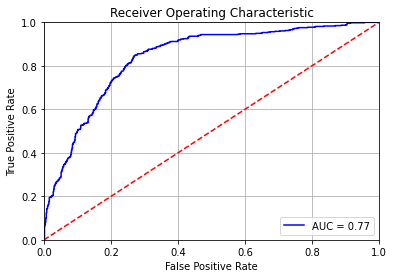

In [15]:
kernel = svm_grid_search_cv.best_params_["kernel"]
best_svm_clf = SVC(kernel=kernel, probability=True)
analysis_best_estimator(df, best_svm_clf)

### Como podemos ver, existe um grande desbalanço entre a precisão e o recall do algoritimo. Isso nos diz que ele está com maior dificuldade em identificar se um planeta é de fato confirmado como exoplaneta ou não, classificando ~ 30% de planetas como confirmado, quando não estão. A precisão baixa, explica o recall mais alto, onde o algoritimo tende a classificar muitas instâncias como confirmado. Logo aumentando a cobertura. No todo, apesar da baixa precisão o algoritmo conseguiu equilibrar a separação ligeiramente bem, mantendo 80% de ROC_AUC.

# KNN K-Nearest Neighbors

### Avaliação do algoritimo KNN variando o número de vizinhos. Conforme aumentamos o número de vizinhos do KNN, aumentamos a robustez do modelo contra possível ruído. Isso porque, conforme aumenta o número de vizinhos, a chance de um dado ruidoso ser diferenciável na classificação é menor. Porém, se muitos vizinhos forem levados em consideração, o modelo pode cair em underfitting e tratar todos os pontos como pertencentes a uma mesma classe.

In [16]:
# Construindo o classificador e o conjunto de parâmetros para busca. Buscaremos até o a altura 20 (4 a mais do esperado).
knn_clf = KNeighborsClassifier()
knn_params = {'n_neighbors': list(range(1, 20))}

# Buscando número de vizinhos ideal para o KNN.
knn_grid_search_cv = hyper_tuning(df, knn_clf, knn_params)

Fitting 5 folds for each of 19 candidates, totalling 95 fits


## Plot da acurácia pela quantidade de vizinhos utilizados em cada modelo.

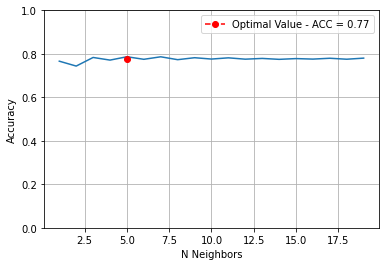

In [17]:
knn_mean_scores = knn_grid_search_cv.cv_results_["mean_test_score"]
plot_graph(knn_mean_scores, 1, len(knn_mean_scores)+1, "N Neighbors")

Precisão:  0.7133550488599348
Recall:  0.8233082706766918
ROC_AUC:  0.7972198050392562


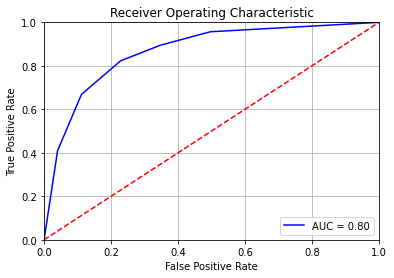

In [18]:
n_neighbors = knn_grid_search_cv.best_params_["n_neighbors"]
best_knn_clf = KNeighborsClassifier(n_neighbors=n_neighbors)
analysis_best_estimator(df, best_knn_clf)

### Como podemos ver, como na análise do SVM, existe um grande desbalanço entre a precisão e o recall do algoritimo. Isso nos diz que ele está com maior dificuldade em identificar se um planeta é de fato confirmado como exoplaneta ou não, classificando ~ 29% de planetas como confirmado, quando não estão. A precisão baixa, explica o recall mais alto, onde o algoritimo tende a classificar muitas instâncias como confirmado. Logo aumentando a cobertura a custa da queda na precisão. O dado pode estar muito misturado e dessa forma, a distância entre vizinhos de duas classes distintas ser próxima para um ponto a ser classificado. O aumento de vizinhos dessa forma, não ajuda significativamente o KNN e leva o algoritimo ao underfitting, que pode ser observado no gráfico. Conforme o número de vizinhos aumenta, a acurácia se mantem cada vez mais estável.

# Random Forest Classifier

### Para avaliar o algoritmo Random Forest, vamos verificar o impacto do aumento da quantidade de árvores utilizadas pelo algoritimo. Métodos de boosting tendem a ser robustos em relação a overfitting, uma vez que vários classificadores são levados em consideração no momento da classificação. Dessa forma, o Random Forest é em teoria robusto a overfitting em relação a quantidade de árvores utilizadas. Porém, um grande número de árvores custa caro computacionalmente e pode atrapalhar o modelo a tomar decisões, se muitas árvores super ajustadas surgirem na classificação. Dessa forma, o objetivo é encontrar a quantidade de árvores que otimiza a acurácia do modelo.

In [19]:
# Construindo instância do classificador RF e configurando espaço de alternativas para o número de árvores.
rf_params = {"n_estimators": list(range(1,100))}
rf_clf = RandomForestClassifier(n_jobs=15, random_state=42)

# Buscando o número ideal de árvores para o algoritimo Random Forest.
rf_grid_search_cv = hyper_tuning(df, rf_clf, rf_params)

Fitting 5 folds for each of 99 candidates, totalling 495 fits


## Gráfico da quantidade de árvores pela acurácia obtida.

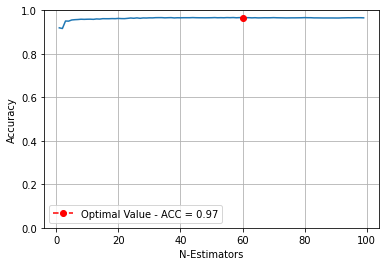

In [20]:
rf_mean_scores = rf_grid_search_cv.cv_results_["mean_test_score"]
plot_graph(rf_mean_scores, 1, len(rf_mean_scores)+1, "N-Estimators")

### A quantidade de árvores que maxiza varia significativamente. Uma altenartiva para reprodutibilidade do modelo para gerar o mesmo número de árvores para decisão é fixar a semente de aleatoriedade do mesmo. Essa estratégia para cenários reais. No estudo em questão, com foco em encontrar um número de estimadores, fixaremos a semente do modelo com o valor 42, somente para fins de reprodutibilidade. Como podemos ver no gráfico logo acima o número de estimadores que maximizou a acurácia do modelo foi 60 (97% de acurácia). Porém, também podemos perceber que, com cinco ou mais árvores a diferença obtida na acurácia é muito baixa, o que não justifica autilização de 60 árvores. Usar vários estimadores implica em um custo computacional maior para se treinar modelos, enquanto com cinco árvores o custo computacional e de tempo é muito inferior. Dessa forma, apesar de um elevado número de elevado de estimadores (60) maximizar a acurácia, cinco ávores apresenta melhor custo benefício entre acurácia e custo computacional.

Precisão:  0.958
Recall:  0.952286282306163
ROC_AUC:  0.9629852464162394


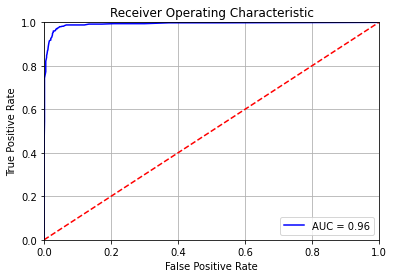

In [21]:
n_estimators = rf_grid_search_cv.best_params_["n_estimators"]
best_rf_clf = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
analysis_best_estimator(df, best_rf_clf)

### O algoritimo se mostrou eficiente em separar os dados e reduzir a quantidade de falsos positivos. O que justifica a precisão e a curva roc estarem mais elevados que o recall, que apesar de estar menor que os dois primeiros, está bem equilibrado, com a cobertura próxima do ideal. Este algoritimo foi o segundo melhor de todos analisados, ficando ligeiramente abaixo do Gradient Booting Tree.

# Gradient Tree Classifier

### Gradient Tree Classifier é um modelo de esemble que otimiza o peso atribuido a importância do votos de classificadores a partir da descida de gradiente na minimização de uma função de erro. Para avaliar esse algoritimo, variamos a quantidade de iterações realizadas na otimização do modelo, que em resumo consiste no número de iterações máximo sem aumento de desempenho que o algoritimo deve atingir para terminar sua execução. Quanto maior o número de execuções , maior a chance do modelo evoluir, porém, maior o custo computacional. Da mesma forma que o algoritmo Random Forest, fixamos a semente de aleatoriedade para gerar resultados reprodutiveis.

In [22]:
# Construindo instância do classificador GTC e espaço de busca por iterações.
gtc_params = {"n_iter_no_change": list(range(1,100))}
gtc_clf = GradientBoostingClassifier(random_state=42)

# Buscando número de iterações ideal para o classificador GTC.
gtc_grid_search_cv = hyper_tuning(df, gtc_clf, gtc_params)

Fitting 5 folds for each of 99 candidates, totalling 495 fits


## Gráfico da quantidade de iterações pela acurácia.

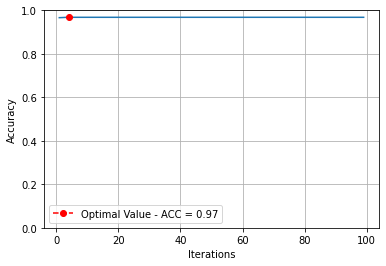

In [23]:
gtc_mean_scores = gtc_grid_search_cv.cv_results_["mean_test_score"]
plot_graph(gtc_mean_scores, 1, len(gtc_mean_scores)+1, "Iterations")

Precisão:  0.9562043795620438
Recall:  0.966789667896679
ROC_AUC:  0.9675845572684976


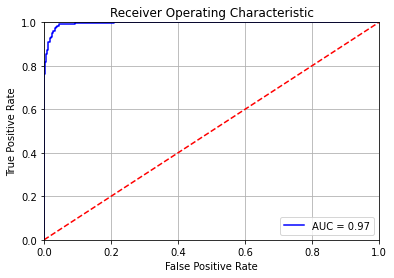

In [24]:
n_iter_no_change = gtc_grid_search_cv.best_params_["n_iter_no_change"]
best_gtc_clf = GradientBoostingClassifier(n_iter_no_change=n_iter_no_change, random_state=42)
analysis_best_estimator(df, best_gtc_clf)

### O número de iterações que levou o algoritimo a acurácia máxima foi 4, porém, esse número poderia variar mais significativamente com a semente de aleatoriedade não fixada. No entando, o algoritmo apresenta resultado superior aos demais, variando pouco no desempenho conforme o número de interações aumenta. Dessa forma, com poucas iterações (i = 4) o algoritimo foi capaz de atingir ~97% de acurácia. Tratando-se do custo beneffício entre consumo computacional e acurácia, um número baixo de iterações é mais indicado, visto que a variação no desempenho do algoritmo ao longo do aumento do número de iterações é mínimo. Por fim, este foi o algoritmo que gerou modelos com maior capacidade de separar planetas confirmados como exoplanetas de planetas não confirmados como mostrado pelo ROC_AUC do algoritimo (97%).

# Conclusão

### Neste notebook avaliamos o desempenho de cinco algoritmos de classificação sobre a base de dados de exoplanetas. Avaliamos todos os modelos com validação cruzada de cinco folds e medidmos o desempenho dos modelos a partir de quatro métricas (precisão, recall, acurácia e curva roc). Mostramos que os algoritmos de árvore obtiveram os melhores resultados, sendo o algoritmo Gradient Boosting Tree o melhor dentro todos com 97% de acurácia e curva roc, seguido pelo algoritimo Random Forest com 97% de acurácia e 96% de curva roc e Decision Tree com 95% de acurária e 96% de curva roc. Todos os algoritimos de árvore superaram a baseline (Algoritimo Naive Bayes com acurácia de 91% e curva roc de 92%). Por outro lado, os algoritmos KNN e SVM tiveram desempenho inferior, atingindo 77% , 80% de acurácia e 76,33% , 77% de curva roc, respectivamente. Desta forma, os algoritmos KNN e SVM ficaram abaixo da baseline do estudo. Para melhorar os resultados obtidos para estes modelos, além da busca por melhores parâmetros, a aplicação e seleção de features e outras técnicas de pré processamento dos dados pode ser de grande ajua.